# Modelling

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from optum_challenge.preprocessing import DataReader, LabelReader, CombinedReader
from optum_challenge.feature_engineering import FeatureEngineering
from optum_challenge.api import Api
from optum_challenge.custom_pipeline_objects import (DropFeatures, ReplaceValueWithNull, Rounder, NumericalMedianImputer, CapFeatures,
                                                     FillNumericNullsWithZero, Binerise, StandardScaler, FillCategoricalNulls, LowerCaseStrings, RareLabelCategoricalEncoder,
                                                     PandasLabelEncoding, ConvertToMatrix)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import joblib
import category_encoders as ce
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, average_precision_score, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall

In [2]:
data_reader = CombinedReader(data_loc='data.csv', label_loc='labels.csv')

In [3]:
df = data_reader.clean_read()

In [4]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,TRUE,GeoData Consultants Ltd,VWC,Roman,FALSE,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,TRUE,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,TRUE,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,TRUE,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,TRUE,GeoData Consultants Ltd,VWC,NaN,TRUE,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0,2011-07-13,Action In A,0.0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,TRUE,GeoData Consultants Ltd,NaN,NaN,TRUE,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Feature Engineering

At this point, I would usually start making new features to help with prediction. However, time is short, so I won't be doing much of it. I'll give an example of what I might do by creating a FeatureEngineering class and make a feature calculating the approx age by using `date_recorded` and `construction_year`.

Generally, you have to be careful about data leakage when feature enginnering since there could be cross contamination between train and validation sets. However, to create age, we are doing everything on a per record basis meaning this isn't a problem.

In [5]:
feature_maker = FeatureEngineering(df)
df = feature_maker.calculate_age()

There are some data points where age is negative due to date recorded being before it was constructed. Strictly speak, these should be removed from train only

In [6]:
df = df[(df.age >= 0) | (df.age.isnull())]

There may be other abnormalities in the data that I haven't found due to time contraints

In [7]:
df.shape

(59388, 42)

# converting targets to number

In [8]:
label_encode = {
    'functional': 0,
    'non functional': 1,
    'functional needs repair': 2
}

# with open('model_objects/label_values.pkl', 'wb') as f:
    
#     joblib.dump(label_encode, f)

In [9]:
df['status_group'] = df.status_group.map(label_encode)

/home/auren/virtual_envs/test_optum/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Splitting data into train, test and validation data

I tend to use a train, valid, test split when building models. It's very hand when using something like LightGBM for model tuning. It also allows me to use the test set less often. I went for 70, 15, 15 split.

In [10]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [11]:
test, valid = train_test_split(test, test_size=0.5, random_state=42)

In [12]:
train.to_parquet('train')
valid.to_parquet('valid')
test.to_parquet('test')

In [13]:
labels_train = train.status_group
labels_valid = valid.status_group
labels_test = test.status_group

train = train.drop('status_group', axis=1)
valid = valid.drop('status_group', axis=1)
test = test.drop('status_group', axis=1)

In [14]:
del(test, labels_test)

In [15]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,age
30416,6815,0,2011-02-25,Private,105.0,DWE,38.865859,-6.763894,John Lyimo,1,Wami / Ruvu,Kigero,Pwani,6,2,Kibaha,Soga,4,TRUE,GeoData Consultants Ltd,Private operator,Upper ruvu,TRUE,2010,mono,mono,motorpump,private operator,commercial,unknown,unknown,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,1.0
4010,5640,100,2011-03-11,Dh,543.0,DH,36.889483,-6.741372,Kwa Bi Asha Mdee,0,Wami / Ruvu,Iganga,Morogoro,5,1,Kilosa,Masanze,300,TRUE,GeoData Consultants Ltd,VWC,NaN,TRUE,1981,other,other,other,vwc,user-group,pay when scheme fails,on failure,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,other,other,30.0
48044,70052,0,2013-02-16,Qwickwin,1303.0,QWICKWIN,34.388646,-1.606847,Shule Ya Msingi Busawe,0,Lake Victoria,Nyambunano,Mara,20,2,Serengeti,Busawe,410,TRUE,GeoData Consultants Ltd,WUG,QWICKWIN,TRUE,2011,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe multiple,communal standpipe,2.0
25907,23666,0,2013-03-30,Government Of Tanzania,1498.0,DWE,36.636605,-3.320262,Kwa Richard,0,Pangani,Sumlei,Arusha,2,2,Arusha Rural,Kimnyaki,150,TRUE,GeoData Consultants Ltd,VWC,Likamba mindeu pipe line,TRUE,1990,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,23.0
12292,64923,0,2012-11-03,Aict,0.0,AICT,33.394978,-3.843131,Kwa Ngelela Kado,0,Internal,Mahameni,Shinyanga,17,3,Shinyanga Rural,Samuye,0,TRUE,GeoData Consultants Ltd,WUG,NaN,FALSE,0,nira/tanira,nira/tanira,handpump,wug,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,NaN


# Preparing to model

I like using ML pipelines when training models since they make reproducing results easier and make it harder for data leakage to occur. Also, something like this is useful when predicting on new unseen datapoints, which may have missing data and will require scaling to the pre-fitted model. I use custom pipeline estimators and transformers that play nice with pandas because the native sklearn ones currently don't.

In [16]:
drop_fields = [
    'id',
    'date_recorded',
    'wpt_name',
    'recorded_by',
    'extraction_type_class',
    'extraction_type_group',
    'payment_type',
    'water_quality',
    'quantity_group',
    'source_type',
    'waterpoint_type_group',
    'region_code',
    'subvillage',
    'ward',    
]

replace_zero_with_null_fields = [
    'amount_tsh',
    'gps_height',
    'population',
    'latitude',
    'longitude',
    'construction_year',
    
]

rounding_fields = [
    'latitude'
]

median_inpute_fields = [
    'amount_tsh',
    'gps_height',
    'population',
    'latitude',
    'longitude',
    'construction_year',
    'age'
    
]

zero_inpute_fields = [
    'num_private'
]

cap_fields = [
    'amount_tsh',
    'gps_height',
    'population',
    'age'
]

standardise_fields = [
    'amount_tsh',
    'gps_height',
    'population',
    'latitude',
    'longitude',
    'construction_year',
    'age'
]

fill_cat_cols = [
    'funder',
    'installer',
    'basin',
    'region',
    'district_code',
    'lga',
    'public_meeting',
    'scheme_management',
    'scheme_name',
    'permit',
    'extraction_type',
    'management',
    'management_group',
    'payment',
    'quality_group',
    'quantity',
    'source',
    'source_class',
    'waterpoint_type'
    ]

lower_case_cols = [col for col in fill_cat_cols if col not in 'district_code']

rare_label_cols = [
    'funder',
    'installer',
    'region',
    'district_code',
    'lga',
    'scheme_management',
    'scheme_name',
    'extraction_type',
    'management'
    ]

encoding_cols = [
    'funder',
    'installer',
    'basin',
    'region',
    'district_code',
    'lga',
    'public_meeting',
    'scheme_management',
    'scheme_name',
    'permit',
    'extraction_type',
    'management',
    'management_group',
    'payment',
    'quality_group',
    'quantity',
    'source',
    'source_class',
    'waterpoint_type'
    ]

In [17]:
preprocessing_pipe = Pipeline(
    [
        ('dropper', DropFeatures(drop_fields)),
        ('rounder', Rounder(rounding_fields)),
        ('changer', ReplaceValueWithNull(variables=replace_zero_with_null_fields)),
        ('median_inputer', NumericalMedianImputer(variables=median_inpute_fields)),
        ('zero_inputer', FillNumericNullsWithZero(variables=zero_inpute_fields)),
        ('cap', CapFeatures(variables=cap_fields)),
        ('turn_binary', Binerise(variables=zero_inpute_fields)),
        ('scale', StandardScaler(variables=standardise_fields)),
        ('fill_cat', FillCategoricalNulls(variables=fill_cat_cols)),
        ('lower', LowerCaseStrings(variables=lower_case_cols)),
        ('rare_inputer', RareLabelCategoricalEncoder(variables=rare_label_cols)),
        ('encoder', PandasLabelEncoding(variables=encoding_cols))
    ]
)

preprocessing_pipe.fit(train)

/home/auren/virtual_envs/test_optum/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Pipeline(memory=None,
         steps=[('dropper', DropFeatures(variables_to_drop=None)),
                ('rounder', Rounder(decimal_places=7, variables=['latitude'])),
                ('changer',
                 ReplaceValueWithNull(val_to_be_replaced=0,
                                      variables=['amount_tsh', 'gps_height',
                                                 'population', 'latitude',
                                                 'longitude',
                                                 'construction_year'])),
                ('median_inputer',
                 NumericalMedianImputer(variables=['amount_tsh...
                                                        'scheme_name',
                                                        'extraction_type',
                                                        'management'])),
                ('encoder',
                 PandasLabelEncoding(variables=['funder', 'installer', 'basin',
                            

In [18]:
# with open('model_objects/data_pipeline.pkl', 'wb') as f:
    
#     joblib.dump(preprocessing_pipe, f)

In [19]:
train = preprocessing_pipe.transform(train)

valid = preprocessing_pipe.transform(valid)

In [20]:
train.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,region,district_code,lga,population,public_meeting,scheme_management,scheme_name,permit,construction_year,extraction_type,management,management_group,payment,quality_group,quantity,source,source_class,waterpoint_type,age
30416,-0.198477,0,-1.930800,0,1.448394,-0.325422,1,0,0,0,0,-0.677849,0,0,0,0,1.188418,0,0,0,0,0,0,0,0,0,-1.344757
4010,-0.372703,0,-1.054262,1,0.679112,-0.317293,0,0,1,1,1,0.239736,0,1,1,0,-1.665168,1,1,1,1,0,0,1,1,1,1.541298
48044,-0.198477,0,0.466670,1,-0.294309,1.536143,0,1,2,0,2,0.580731,0,2,0,0,1.286818,2,2,1,2,0,1,2,1,2,-1.245238
25907,-0.198477,1,0.856909,0,0.580683,0.917643,0,2,3,0,3,-0.225256,0,1,0,0,-0.779572,2,1,1,2,0,0,2,1,0,0.844664
12292,-0.198477,0,0.194503,1,-0.681082,0.728900,0,3,4,2,0,-0.225256,0,2,1,1,0.204423,3,2,1,2,0,1,1,1,3,-0.150527


# Modelling

# making input sklearn friendly

In [21]:
binary_encode_cols = [
    'funder',
    'installer',
    'region', 
    'district_code', 
    'lga',
    'scheme_management']

one_hot_encode_cols = [
    'basin',
    'public_meeting',
    'scheme_name',
    'permit',
    'extraction_type',
    'management',
    'management_group',
    'payment',
    'quality_group',
    'quantity',
    'source',
    'source_class',
    'waterpoint_type'
]

In [22]:
sklearn_pipe = Pipeline([
    ('one_hot_encode', ce.OneHotEncoder(cols=one_hot_encode_cols)),
    ('binary_encode', ce.BinaryEncoder(cols=binary_encode_cols)),
    ('convert_matrix', ConvertToMatrix())
])

In [23]:
sklearn_pipe.fit(train)

Pipeline(memory=None,
         steps=[('one_hot_encode',
                 OneHotEncoder(cols=['basin', 'public_meeting', 'scheme_name',
                                     'permit', 'extraction_type', 'management',
                                     'management_group', 'payment',
                                     'quality_group', 'quantity', 'source',
                                     'source_class', 'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=False, verbose=0)),
                ('binary_encode',
                 BinaryEncoder(cols=['funder', 'installer', 'region',
                                     'district_code', 'lga',
                                     'scheme_management'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value'

In [24]:
train_sklearn = sklearn_pipe.transform(train)
valid_sklearn = sklearn_pipe.transform(valid)

## Step 1: Get a baseline to compare all results too

As a sanity check, I usually make a 'guess' model to compare any results to

In [25]:
dummy = DummyClassifier(strategy='stratified')

dummy.fit(train_sklearn, labels_train)

dummy_prob = dummy.predict_proba(valid_sklearn)
dummy_pred = dummy.predict(valid_sklearn)

In [26]:
print(classification_report(labels_valid, dummy_pred))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      4742
           1       0.39      0.39      0.39      3519
           2       0.08      0.08      0.08       648

    accuracy                           0.45      8909
   macro avg       0.34      0.34      0.34      8909
weighted avg       0.45      0.45      0.45      8909



In [27]:
roc_auc_score(y_true=labels_valid, y_score=dummy_prob, multi_class='ovr')

0.4975581720873996

The model(s) I build should beat this, otherwise they are useless

## Step 2: Simple model (Logistic)

In [28]:
lr_basic = LogisticRegression(n_jobs=-1, random_state=42)

In [29]:
lr_basic.fit(train_sklearn, labels_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=42,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [30]:
lr_basic_prob = lr_basic.predict_proba(valid_sklearn)
lr_basic_pred = lr_basic.predict(valid_sklearn)

In [31]:
print(classification_report(labels_valid, lr_basic_pred))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79      4742
           1       0.80      0.63      0.70      3519
           2       0.51      0.08      0.14       648

    accuracy                           0.73      8909
   macro avg       0.67      0.54      0.55      8909
weighted avg       0.73      0.73      0.71      8909



In [32]:
roc_auc_score(y_true=labels_valid, y_score=lr_basic_prob, multi_class='ovr')

0.8211209453283974

From the most basic implementation we see logistic regression can model this data well. Due to the class imbalance, label 2 (needs repair) didn't improve much. We can try add 'more weight' to those entries to help this. By place 'more weight' I mean the model will penalise mistakes in that class more when weighting. Generally the effect of this is, other classes can get slightly worse but minority class gets better, improving metrics overall.

## Step 3: Balanced Logistic

In [33]:
lr_bal = LogisticRegression(n_jobs=-1, random_state=42, class_weight='balanced')

In [34]:
lr_bal.fit(train_sklearn, labels_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
lr_bal_prob = lr_bal.predict_proba(valid_sklearn)
lr_bal_pred = lr_bal.predict(valid_sklearn)

In [36]:
print(classification_report(labels_valid, lr_bal_pred))

              precision    recall  f1-score   support

           0       0.77      0.63      0.70      4742
           1       0.77      0.63      0.70      3519
           2       0.19      0.64      0.29       648

    accuracy                           0.63      8909
   macro avg       0.58      0.63      0.56      8909
weighted avg       0.73      0.63      0.67      8909



In [37]:
roc_auc_score(y_true=labels_valid, y_score=lr_bal_prob, multi_class='ovr')

0.8164335295659075

Weighting each label equally improves metrics for label 2 (needs repairs) but labels 1 and 2 metrics are reduced as expected. When to use different weightings completely depends on the model use case. If you want to use the model to figure out which ones need repairing, I would weight. If you purely care about highest metrics possible, don't weight.

In this instance, I think it's important to find ones that need repair so will stick to weighting.

## Step 3: Balanced Logistic + regularisation

By regularising during training, we may increase metrics by simplifying the model, thus reducing overfitting.

In [38]:
lr_bal_reg = LogisticRegression(n_jobs=-1, random_state=42, class_weight='balanced')

In [39]:
model_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    }
    
grid_search = RandomizedSearchCV(estimator=lr_bal_reg, param_distributions=model_params, cv=5, n_jobs=-1, random_state=42, n_iter=50)

In [40]:
grid_search.fit(train_sklearn, labels_train)

/home/auren/virtual_envs/test_optum/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=-1,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=50, n_jobs=-1,
                   param_distributions={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                              0.1, 1, 10],
                                        'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                     0.6, 0.7, 

In [41]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.1,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
lr_bal_reg_prob = grid_search.predict_proba(valid_sklearn)
lr_bal_reg_pred = grid_search.predict(valid_sklearn)

In [43]:
print(classification_report(labels_valid, lr_bal_reg_pred))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69      4742
           1       0.77      0.63      0.69      3519
           2       0.19      0.64      0.30       648

    accuracy                           0.63      8909
   macro avg       0.58      0.63      0.56      8909
weighted avg       0.73      0.63      0.66      8909



In [44]:
roc_auc_score(y_true=labels_valid, y_score=lr_bal_reg_prob, multi_class='ovr')

0.8162381821161064

In [45]:
lr_bal_reg_prob_train = grid_search.predict_proba(train_sklearn)
lr_bal_reg_pred_train = grid_search.predict(train_sklearn)

In [46]:
print(classification_report(labels_train, lr_bal_reg_pred_train))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71     22669
           1       0.78      0.64      0.70     15896
           2       0.19      0.65      0.30      3006

    accuracy                           0.64     41571
   macro avg       0.59      0.64      0.57     41571
weighted avg       0.74      0.64      0.68     41571



In [48]:
roc_auc_score(y_true=labels_train, y_score=lr_bal_reg_prob_train, multi_class='ovr')

0.8234348584536845

Additonal regularisation (other than the default) doesn't change metrics much. This, along with comparing train and validation scores, suggests that this model isn't overfit and it close to best what logistic regression can do with these features.

The next step is to use a more sophisticated modelling technique, such as boosting to see can we get a lift from logistic. I expect there to be since it can capture interactions and non-linearities in the data. Perhaps especially for lat-long features. I know there is many things that can be done with co-ordinates to make features but this was outside the scope of this. Perhaps if I had more time.

I will wait until the final model to find best features. In theory this can be an intermediate step, finding best features, creating new features from it etc.

For Logistic, you can get an idea from the coefficients but I've always found it not super useful when mixed continous/binary features, since the actual contribution for a continuous feature scales the product of it and coefficient. 

# Step 4: LightGBM

In [49]:
class_weights = compute_class_weight('balanced',
                                     np.unique(labels_train),
                                     labels_train)

weights = np.where(labels_train == 0, class_weights[0],
                   np.where(labels_train == 1, class_weights[1], class_weights[2]))

In [50]:
train_lgb = lgb.Dataset(data=train,
                        label=labels_train,
                        weight=weights,
                        categorical_feature=encoding_cols,
                        feature_name=list(train.columns),
                        free_raw_data=False)

valid_lgb = lgb.Dataset(data=valid,
                        label=labels_valid,
                        reference=train_lgb)

In [51]:
param_basic = {
    'objective':'multiclass',
    'num_class': 3,
    'n_estimators': 3000
}

In [52]:
lgb_model = lgb.train(params=param_basic,
                      train_set=train_lgb,
                      valid_sets=[train_lgb, valid_lgb],
                      early_stopping_rounds=50)

/home/auren/virtual_envs/test_optum/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/auren/virtual_envs/test_optum/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/auren/virtual_envs/test_optum/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['basin', 'district_code', 'extraction_type', 'funder', 'installer', 'lga', 'management', 'management_group', 'payment', 'permit', 'public_meeting', 'quality_group', 'quantity', 'region', 'scheme_management', 'scheme_name', 'source', 'source_class', 'waterpoint_type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	training's multi_logloss: 1.05283	valid_1's multi_logloss: 1.05504
Training until validation scores don't improve for 50 rounds
[2]	training's multi_logloss: 1.01359	valid_1's multi_logloss: 1.01767
[3]	training's multi_logloss: 0.979726	valid_1's multi_logloss: 0.985339
[4]	training's multi_logloss: 0.950183	valid_1's multi_logloss: 0.957511
[5]	training's multi_logloss: 0.923949	valid_1's multi_logloss: 0.933156
[6]	training's multi_logloss: 0.90093	valid_1's multi_logloss: 0.911643
[7]	training's multi_logloss: 0.880479	valid_1's multi_logloss: 0.892363
[8]	training's multi_logloss: 0.862014	valid_1's multi_logloss: 0.874929
[9]	training's multi_logloss: 0.845335	valid_1's multi_logloss: 0.859365
[10]	training's multi_logloss: 0.830529	valid_1's multi_logloss: 0.84549
[11]	training's multi_logloss: 0.816747	valid_1's multi_logloss: 0.832665
[12]	training's multi_logloss: 0.803748	valid_1's multi_logloss: 0.820882
[13]	training's multi_logloss: 0.792205	valid_1's multi_logloss: 0

In [53]:
lgb_basic_probs = lgb_model.predict(valid)
lgb_basic_preds = np.argmax(lgb_basic_probs, axis=1)

In [54]:
print(classification_report(labels_valid, lgb_basic_preds))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      4742
           1       0.84      0.78      0.81      3519
           2       0.35      0.59      0.44       648

    accuracy                           0.77      8909
   macro avg       0.67      0.72      0.69      8909
weighted avg       0.80      0.77      0.78      8909



In [55]:
roc_auc_score(y_true=labels_valid, y_score=lgb_basic_probs, multi_class='ovr')

0.8978035766232514

Using the default settings, this model is far better than any tuned logistic model. This implies there could be non-linearities in the data as well as feature interaction. I'm not surprised by this result and GBM will generally outperfrom logistics in most tasks (unless low data and all features linear)

I could spend more time, tuning the many hyperparameters, but I won't.

In [56]:
# with open('model_objects/final_model.pkl', 'wb') as f:
    
#     joblib.dump(lgb_model, f)

# Step 5: Getting metrics on test dataset

Since I'm going to use the lightgbm model as my 'production' model, we need to get metrics on it on unseen data. So far, only valid data has been used and as such, test data will give a clearer picture of how this model will work on unseen data

In [57]:
test = pd.read_parquet('test')
labels_test = test.status_group
test = test.drop('status_group', axis=1)

In [58]:
test = preprocessing_pipe.transform(test)

In [59]:
final_model_probs = lgb_model.predict(test)
final_model_preds = np.argmax(final_model_probs, axis=1)

In [60]:
print(classification_report(labels_test, final_model_preds))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81      4843
           1       0.83      0.77      0.80      3403
           2       0.34      0.59      0.43       662

    accuracy                           0.77      8908
   macro avg       0.67      0.72      0.68      8908
weighted avg       0.80      0.77      0.78      8908



In [61]:
roc_auc_score(y_true=labels_test, y_score=final_model_probs, multi_class='ovr')

0.8912705749880506

## Visualising results

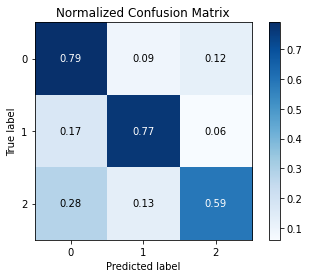

In [62]:
plot_confusion_matrix(y_true=labels_test, y_pred=final_model_preds, normalize=True)

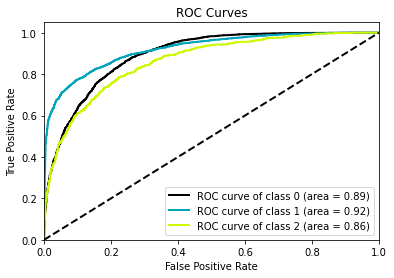

In [63]:
plot_roc(y_true=labels_test, y_probas=final_model_probs, plot_micro=False, plot_macro=False)

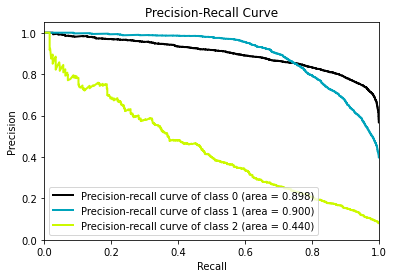

In [64]:
plot_precision_recall(y_true=labels_test, y_probas=final_model_probs, plot_micro=False)
plt.legend(loc='lower left')

# Step 6: Finding the most important features

* I use 2 method to find most import features: native feature importance ~~and shap values~~
* There are many methods to find important features and from my experience, they can contradict each other. ~~Hence, I'm using 2~~ It was taking too long, if I had more time I would of used shap too.

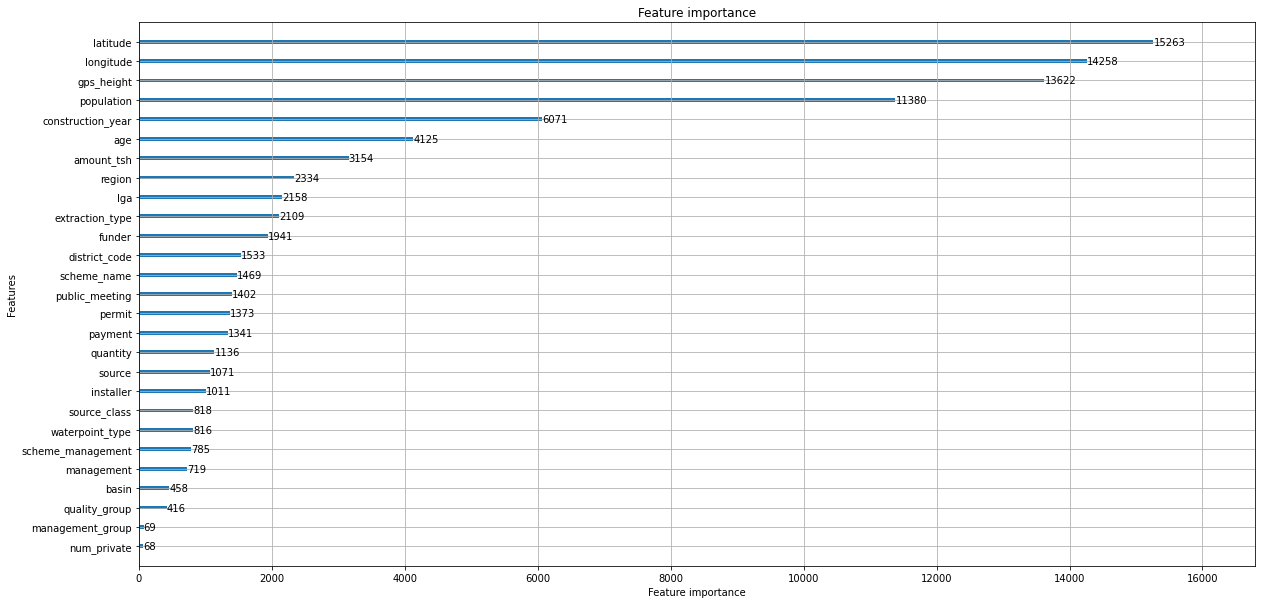

In [65]:
lgb.plot_importance(lgb_model, importance_type='split', figsize=(20,10))

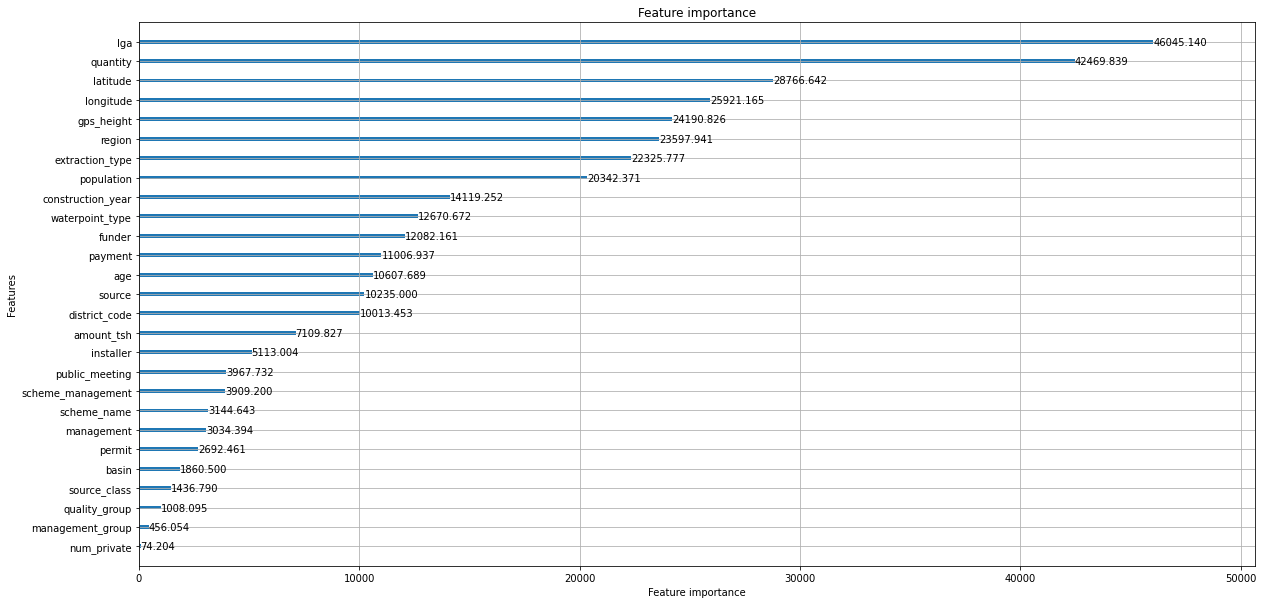

In [66]:
lgb.plot_importance(lgb_model, importance_type='gain', figsize=(20,10))

Even within Lightgbm, there isn't full agreement between methods but what we can take from this is:

1) Location is very important in terms of functionality

2) The amount of people using it (probably related to location)

3) How it was extracted/water type

4) How old it is

5) Who paid for it

# Final Step: Deploy model

This is often times, the most ignored part of the process by data scientists. Here, I'll create a mock 'API' to show how this model could be deployed in production on new data. The code for this is in the module under api.py

* API uses the model fitted above
* data is input as (multiline) string in raw form, how I got the data from `data.csv`
* headers are not to be inserted

In [67]:
test_str = """66453,500,2013-11-02,Danida,519.0,DANIDA,34.65405418,-11.03302193,Kwa Mzee Nkanyuka,0,Lake Nyasa,Mungano,Ruvuma,10,3,Mbinga,Kihagara,60,TRUE,GeoData Consultants Ltd,VWC,DANIDA,TRUE,1992,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe"""

In [68]:
api_call = Api(post=test_str)

In [69]:
api_call.get()

{'id': '66453', 'prediction': 'functional'}

The api can also do a multiline call (or batch)

In [70]:
test_multi = """66453,500,2013-11-02,Danida,519.0,DANIDA,34.65405418,-11.03302193,Kwa Mzee Nkanyuka,0,Lake Nyasa,Mungano,Ruvuma,10,3,Mbinga,Kihagara,60,TRUE,GeoData Consultants Ltd,VWC,DANIDA,TRUE,1992,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
43686,2000,2011-03-14,Dhv,125.0,DWE,37.85396755,-7.19712582,Shuleni,0,Wami / Ruvu,Barani,Morogoro,5,2,Morogoro Rural,Mvuha,300,TRUE,GeoData Consultants Ltd,VWC,,TRUE,1996,other,other,other,vwc,user-group,pay monthly,monthly,salty,salty,seasonal,seasonal,shallow well,shallow well,groundwater,other,other
69472,0,2011-07-11,Hesawa,0.0,HESAWA,30.64852489,-2.49417232,Kwa Mserikali,0,Lake Victoria,Buhororo Kati,Kagera,18,30,Ngara,Kibimba,0,TRUE,GeoData Consultants Ltd,VWC,,FALSE,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,enough,enough,spring,spring,groundwater,other,other
"""

In [71]:
multi_api_call = Api(post=test_multi)

In [72]:
multi_api_call.get()

[{'id': '66453', 'prediction': 'functional'},
 {'id': '43686', 'prediction': 'non functional'},
 {'id': '69472', 'prediction': 'functional needs repair'}]

Feel free to try it yourself with new data!

# Conclusions

In reference to the project instructions:
    
1) Carry out exploratory analysis on the dataset. Create an appropriate visualization of each feature.

* This is done in `initial_eda.ipynb` and `eda_visualisation.ipynb`
* The visualisations were getting tedious so stopped after many
* If more time, I would of completed this

2) The file (data.csv) contains a target value which we will use to build a classification model. Join the two files using the ID column. Be prepared to describe any pitfalls in joining.

* Described in `initial_eda.ipynb` and in `CombinedReader` class

3) Determine whether any missing or corrupt values need to be handled. Be prepared to discuss how you identified missing or corrupt values and how you handled them.

* anomalous data found throughout
* Generally dealt with by dropping fields, repairing or during ML pipeline with reducing levels etc
* If I had more time, I found of found and fixed more.

4) Determine whether any of the numeric features are correlated. What impact might this have for modeling and how can it be mitigated

* Correlation of continuous fields wasn't deemed a big problem
* Methods to deal with it are still addressed

5) Some of the variables are categoric. Come up with a scheme for handling categorical variables

* This is addressed in the preprocessing pipeline in this notebook

6) Given the above steps – prepare a final dataset for predicting the status_group target

* Done at start of this notebook

7) Carry out a machine learning exercise to predict status_group

* In this notebook and I comment on the method throughout

8) What else what you have done with this dataset given more time?

I've specified some of this already but in general:

* More EDA time
* Better visualisations
* Trying different combinations of features
* More modelling algorithms
* Better model tuning
* Create a web API for calling model rather than mock one used above
* Add more documentation to the python module
* Add more comments in notebooks
* Unit test the python package